# Notebook for training computer vision models for BugID

## Load libraries and data

In [1]:
#Load libraries and constants
import timm
from fastai.vision.all import *
import pandas as pd
from torchvision import transforms
import torch
import cv2
import numpy as np
import shap
import torchvision

image_dir = Path("image_preproc")
model_dir = Path("models")
data_dir = Path("data")

img_size = 300

/home/kenneth/anaconda3/envs/pytorch/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/kenneth/anaconda3/envs/pytorch/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_min

In [2]:
#Calculate weigths per class because of imbalanced data distribution
targets = [parent_label(i) for i in get_image_files(image_dir)]
count = Counter(targets)
wgts = [1/count[i] for i in targets]
n_classes = len(count)

In [3]:
#Define dataloaders
bs = 32

block = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items = get_image_files,
                  splitter = GrandparentSplitter(),
                  item_tfms=Resize(360, method=ResizeMethod.Crop), 
                  batch_tfms=aug_transforms(mult=1, size=img_size, min_scale=0.3, flip_vert=True),
                  get_y = parent_label)
    
loaders = block.weighted_dataloaders(image_dir, wgts=wgts, bs=bs)

In [5]:
#Write model vocabolary to file
vocab = loaders.vocab

with open(data_dir/"vocab.txt", 'w') as f:
    f.write('\n'.join(vocab))

In [4]:
#Function to count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters()) # if p.requires_grad

## Benchmark models

In [5]:
#List learners to benchmark
learners = ["resnet18", "resnet34", "resnet50", 
            "mobilenetv2_050", "mobilenetv2_100", "mobilenetv2_140",
            "convnext_nano", "convnext_tiny"]

In [ ]:
#Iterate over all learners and obtain validation statistics
results = []

for name in learners:
    
    #Define learner
    learn = vision_learner(loaders, 
                           name,
                           pretrained=True,
                           normalize=True,
                           loss_func=LabelSmoothingCrossEntropy(),
                           metrics=[accuracy, top_k_accuracy],
                           cbs=SaveModelCallback(fname=name)).to_fp16()

    #Fine-tune learner
    learn.fine_tune(epochs=15, freeze_epochs=3)

    #Count parameters
    n_params = count_parameters(learn)

    #Get validation set metrics
    preds, targets = learn.get_preds()

    val_acc = accuracy(preds, targets)
    val_top5 = top_k_accuracy(preds, targets)
    
    results.append({"model": name, "val_acc": val_acc.item(), "val_top5": val_top5.item(), "n_params": n_params})

In [18]:
#Export benchmark results
results_df = pd.DataFrame(results)
results_df.to_csv(data_dir/"benchmark.csv", index=False)

## Inspect models 

In [4]:
#Load learner for inspection and export
model_name = "convnext_nano"

learn = vision_learner(loaders, 
                       model_name,
                       pretrained=True,
                       normalize=True).load(model_name)


Saved filed doesn't contain an optimizer state.


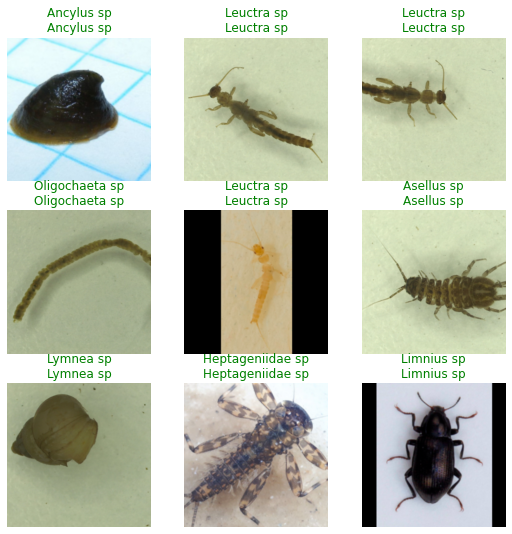

In [5]:
#Show example predictions
learn.show_results()

In [6]:
#Create confusion matrix
interpreter = ClassificationInterpretation.from_learner(learn)

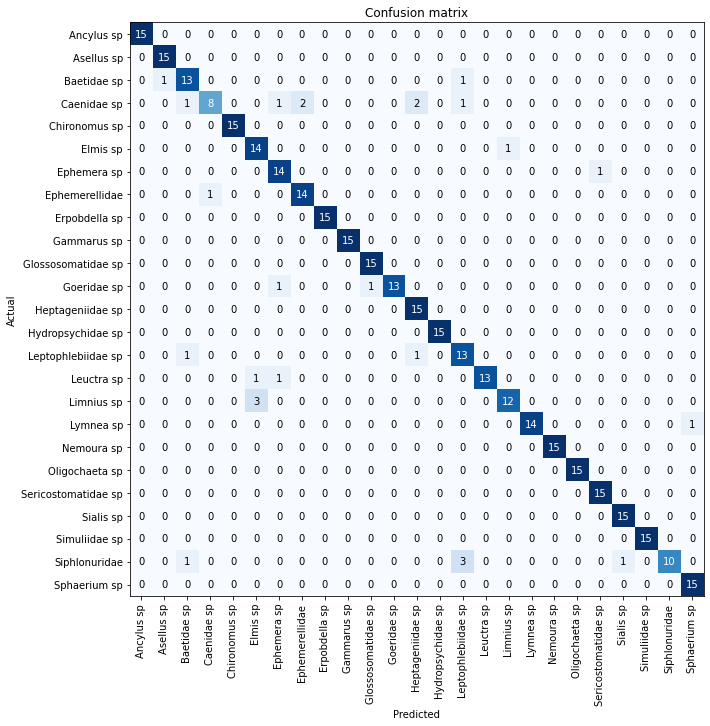

In [7]:
interpreter.plot_confusion_matrix(figsize=(10,10))

## Export models to ONNX format

In [8]:
#Define normalization layer
normalization_layer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

torch_model = learn.model.cpu()

#Define softmax layer
softmax_layer = torch.nn.Softmax(dim=-1) 

#Assemble the final model
final_model = nn.Sequential(normalization_layer, torch_model, softmax_layer)
final_model.eval()

Sequential(
  (0): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  (1): Sequential(
    (0): TimmBody(
      (model): ConvNeXt(
        (stem): Sequential(
          (0): Conv2d(3, 80, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm2d((80,), eps=1e-06, elementwise_affine=True)
        )
        (stages): Sequential(
          (0): ConvNeXtStage(
            (downsample): Identity()
            (blocks): Sequential(
              (0): ConvNeXtBlock(
                (conv_dw): Conv2d(80, 80, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=80)
                (norm): LayerNorm2d((80,), eps=1e-06, elementwise_affine=True)
                (mlp): Mlp(
                  (fc1): Conv2d(80, 320, kernel_size=(1, 1), stride=(1, 1))
                  (act): GELU()
                  (drop1): Dropout(p=0.0, inplace=False)
                  (norm): Identity()
                  (fc2): Conv2d(320, 80, kernel_size=(1, 1), stride=(1, 1))
                  (drop2): 

In [9]:
#Generate model sample input
dummy_input = torch.randn(1, 3, img_size, img_size, requires_grad=True)

onnx_model_path = model_dir/f"{model_name}.onnx"

In [ ]:
#https://docs.opencv.org/4.x/dc/d70/pytorch_cls_tutorial_dnn_conversion.html
#Model export into ONNX format
torch.onnx.export(
    final_model,
    dummy_input,
    onnx_model_path,
    export_params=True,
    do_constant_folding=True,
    input_names = ['input'],
    output_names = ['output']
)

## Test fastai and ONNX model predictions

In [11]:
#Test fastai and ONNX model predictions
image_sample = "image_preproc/valid/Asellus sp/CPH-Asellus sp.-15.png"

In [12]:
#Get fastai predictions for sample image
spec, idx, probs = learn.predict(image_sample)

In [13]:
#Load ONNX model using opencv
model = cv2.dnn.readNetFromONNX(f"models/{model_name}.onnx")

In [13]:
def img_preproc(path):
    image = cv2.imread(path)
    preproc = cv2.dnn.blobFromImage(
                image = image,
                scalefactor = 1/255,
                size = (img_size, img_size),
                swapRB=True,
                crop=True)
    
    return preproc

In [14]:
#Preprocess sample image using opencv (similar to GUI)
model_input = img_preproc(image_sample)

In [15]:
#Get ONNX model predictions
model.setInput(model_input)
probs_onnx = model.forward().squeeze()

In [16]:
probs_onnx, probs.numpy()

(array([2.3083619e-03, 9.2065763e-01, 5.8107864e-04, 4.0610568e-03,
        2.3187485e-03, 6.5948390e-03, 7.8800262e-04, 1.4424482e-03,
        3.0404367e-03, 1.1304687e-02, 1.2979949e-03, 3.6845184e-03,
        1.2025620e-03, 3.2048381e-03, 3.9071264e-04, 4.8711961e-03,
        2.1368258e-03, 2.4587093e-03, 2.2930349e-03, 2.2373155e-03,
        3.5093972e-03, 1.0730162e-02, 1.7481861e-03, 3.3497233e-03,
        3.7875238e-03], dtype=float32),
 array([1.0834065e-03, 9.6167344e-01, 3.2505573e-04, 2.0606818e-03,
        1.1313492e-03, 3.0834784e-03, 3.3985754e-04, 7.8537187e-04,
        1.5964077e-03, 6.6239787e-03, 7.2213047e-04, 1.9442525e-03,
        5.6345476e-04, 1.0570571e-03, 2.1280341e-04, 2.1971972e-03,
        1.0461808e-03, 1.4970399e-03, 1.0500876e-03, 1.0937245e-03,
        1.2470942e-03, 4.6010669e-03, 7.9464400e-04, 1.5248683e-03,
        1.7454615e-03], dtype=float32))

## Perform SHAP interpretation

In [115]:
#https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20MobilenetV2%20using%20the%20Partition%20explainer%20%28PyTorch%29.html


In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = nn.Sequential(normalization_layer, torch_model)

model.eval()
model.to(device)


Sequential(
  (0): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  (1): Sequential(
    (0): TimmBody(
      (model): ConvNeXt(
        (stem): Sequential(
          (0): Conv2d(3, 80, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm2d((80,), eps=1e-06, elementwise_affine=True)
        )
        (stages): Sequential(
          (0): ConvNeXtStage(
            (downsample): Identity()
            (blocks): Sequential(
              (0): ConvNeXtBlock(
                (conv_dw): Conv2d(80, 80, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=80)
                (norm): LayerNorm2d((80,), eps=1e-06, elementwise_affine=True)
                (mlp): Mlp(
                  (fc1): Conv2d(80, 320, kernel_size=(1, 1), stride=(1, 1))
                  (act): GELU()
                  (drop1): Dropout(p=0.0, inplace=False)
                  (norm): Identity()
                  (fc2): Conv2d(320, 80, kernel_size=(1, 1), stride=(1, 1))
                  (drop2): 

In [10]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def nhwc_to_nchw(x):
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x):
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x

#transform= [
#    torchvision.transforms.Lambda(nhwc_to_nchw),
#    torchvision.transforms.Lambda(lambda x: x*(1/255)),
#    torchvision.transforms.Normalize(mean=mean, std=std),
#    torchvision.transforms.Lambda(nchw_to_nhwc),
#]

inv_transform= [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

#transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

def predict(img):
    img = torch.Tensor(img)
    img = nhwc_to_nchw(img)
    img = img.to(device)
    
    with torch.no_grad():  
        output = model(img)
        
    return output

class_names = learn.dls.vocab

In [67]:
imgs_list = ["image_preproc/valid/Asellus sp/CPH-Asellus sp.-15.png",
             "image_preproc/valid/Nemoura sp/CPH-Nemoura sp.-2266.png"]

X = np.stack([img_preproc(i) for i in imgs_list])
X = torch.Tensor(X.squeeze().transpose((0, 2, 3, 1)))

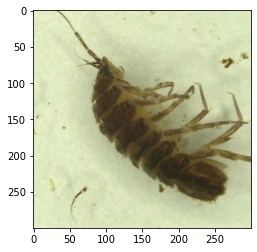

In [68]:
plt.imshow(X[0].numpy())

In [43]:
y_hat = predict(X)
torch.nn.Softmax(dim=1)(y_hat)

tensor([[2.3084e-03, 9.2066e-01, 5.8108e-04, 4.0610e-03, 2.3187e-03, 6.5948e-03,
         7.8800e-04, 1.4425e-03, 3.0404e-03, 1.1305e-02, 1.2980e-03, 3.6845e-03,
         1.2026e-03, 3.2048e-03, 3.9071e-04, 4.8712e-03, 2.1368e-03, 2.4587e-03,
         2.2930e-03, 2.2373e-03, 3.5094e-03, 1.0730e-02, 1.7482e-03, 3.3497e-03,
         3.7875e-03],
        [4.8954e-03, 7.4052e-03, 1.9729e-03, 5.6353e-03, 6.0165e-03, 3.9165e-03,
         4.2625e-03, 1.0689e-02, 4.7352e-03, 3.8282e-03, 3.4255e-03, 3.8400e-03,
         1.6592e-03, 1.3871e-02, 1.9400e-03, 4.9804e-03, 4.6594e-03, 4.8096e-03,
         8.8077e-01, 3.8712e-03, 3.9616e-03, 3.0927e-03, 3.5195e-03, 4.2966e-03,
         7.9477e-03]], device='cuda:0')

In [44]:
classes = torch.argmax(y_hat, axis=1).cpu().numpy()
print(f'Classes: {classes}: {np.array(class_names)[classes]}')

Classes: [ 1 18]: ['Asellus sp' 'Nemoura sp']


In [45]:
topk = 4
batch_size = 50
n_evals = 1000

masker_blur = shap.maskers.Image("blur(128,128)", X[0].shape)

explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

shap_values = explainer(X, max_evals=n_evals, batch_size=batch_size,
                        outputs=shap.Explanation.argsort.flip[:topk])

In [46]:
(shap_values.data.shape, shap_values.values.shape)


(torch.Size([2, 300, 300, 3]), (2, 300, 300, 3, 4))

In [47]:
shap_values.data = inv_transform(shap_values.data).cpu().numpy()
shap_values.values = [val for val in np.moveaxis(shap_values.values,-1, 0)]

In [48]:
(shap_values.data.shape, shap_values.values[0].shape)


((2, 300, 300, 3), (2, 300, 300, 3))

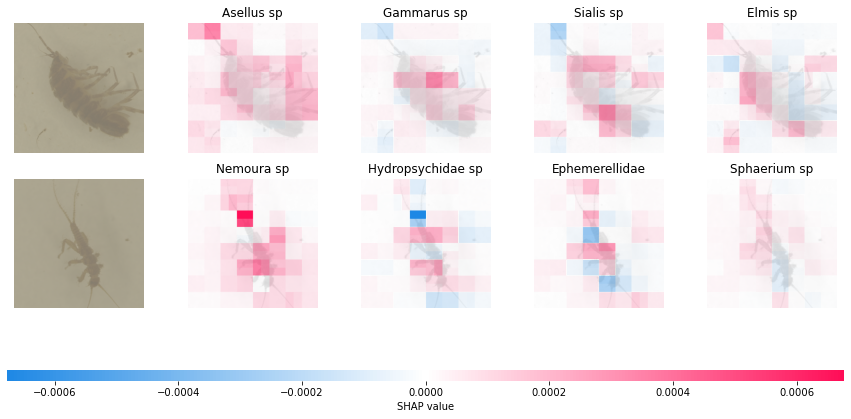

In [49]:
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)

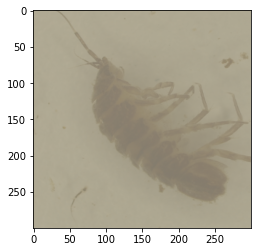

In [66]:
plt.imshow(shap_values.data[0])

In [70]:
shap_values.data[0].max()

0.6996314